In [1]:
import glob
import json
import os
from pathlib import Path
import numpy as np
import pandas as pd
from siuba import group_by, summarize, arrange, filter, mutate, if_else, _
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import seaborn.objects as so

import torch
from torchvision import transforms
from multimodal.multimodal_lit import MultiModalLitModel
import clip
from sklearn.manifold import TSNE
from PIL import Image

In [26]:
# saycam labeled s results plot
saycam_results_filenames = glob.glob("../results/*saycam*.json")

saycam_results = []
for filename in saycam_results_filenames:
    with open(filename) as f:
        data = json.load(f)

    result_df = pd.DataFrame(data["data"])
    result_df["target_category"] = result_df["categories"].str[0]
    
    # add extra columns
    if "augment_frames" not in result_df.columns:
        result_df["augment_frames"] = True
    if "multiple_frames" not in result_df.columns:
        result_df["multiple_frames"] = True
    
    saycam_results.append(result_df)
    
# combine results
saycam_results_df = pd.concat(saycam_results)

/home/wv9/code/WaiKeen/miniconda3/envs/multimodal-baby/lib/python3.8/_collections_abc.py:832: MatplotlibDeprecationWarning: 
The savefig.jpeg_quality rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  self[key] = other[key]
/home/wv9/code/WaiKeen/miniconda3/envs/multimodal-baby/lib/python3.8/_collections_abc.py:832: MatplotlibDeprecationWarning: 
The savefig.jpeg_quality rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  self[key] = other[key]


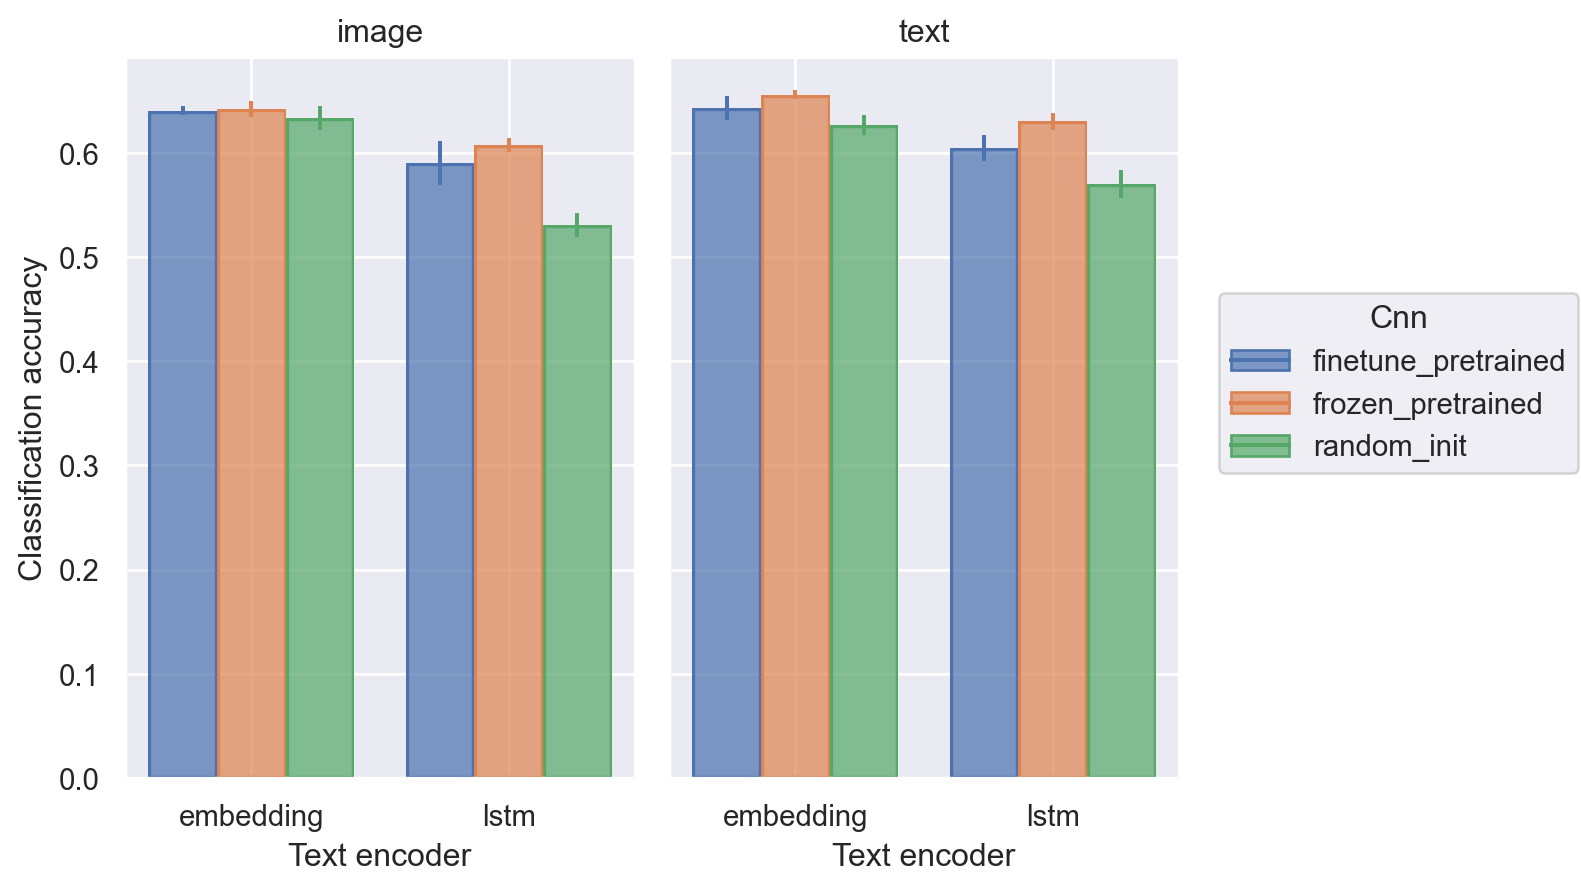

In [27]:
# summary figure
saycam_summary_diff_init = (saycam_results_df
>> filter(_.shuffle_utterances == False, _.augment_frames == True, _.multiple_frames == True)
>> group_by(_.cnn, _.model, _.seed, _.eval_type)
>> summarize(correct = _.correct.mean()))

(
    so.Plot(saycam_summary_diff_init, x="model", y="correct", color="cnn")
    .facet("eval_type")
    .add(so.Bar(), so.Agg(), so.Dodge())
    .add(so.Range(), so.Est(errorbar="se"), so.Dodge())
    .label(
        x="Text encoder", y="Classification accuracy",
        color=str.capitalize)
    #.save('../paper/figures/labeled-s-results.pdf', dpi=300, bbox_inches="tight")
)

    seed eval_type augment_frames  multiple_frames   correct
0      0     image    no_data_aug  multiple_frames  0.628636
1      0     image       data_aug     single_frame  0.585909
2      0     image       data_aug  multiple_frames  0.647727
3      0      text    no_data_aug  multiple_frames  0.633636
4      0      text       data_aug     single_frame  0.591364
5      0      text       data_aug  multiple_frames  0.651818
6      1     image    no_data_aug  multiple_frames  0.638636
7      1     image       data_aug     single_frame  0.588182
8      1     image       data_aug  multiple_frames  0.630909
9      1      text    no_data_aug  multiple_frames  0.653182
10     1      text       data_aug     single_frame  0.606364
11     1      text       data_aug  multiple_frames  0.655909
12     2     image    no_data_aug  multiple_frames  0.629091
13     2     image       data_aug     single_frame  0.594091
14     2     image       data_aug  multiple_frames  0.648182
15     2      text    no

/home/wv9/code/WaiKeen/miniconda3/envs/multimodal-baby/lib/python3.8/_collections_abc.py:832: MatplotlibDeprecationWarning: 
The savefig.jpeg_quality rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  self[key] = other[key]
/home/wv9/code/WaiKeen/miniconda3/envs/multimodal-baby/lib/python3.8/_collections_abc.py:832: MatplotlibDeprecationWarning: 
The savefig.jpeg_quality rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  self[key] = other[key]


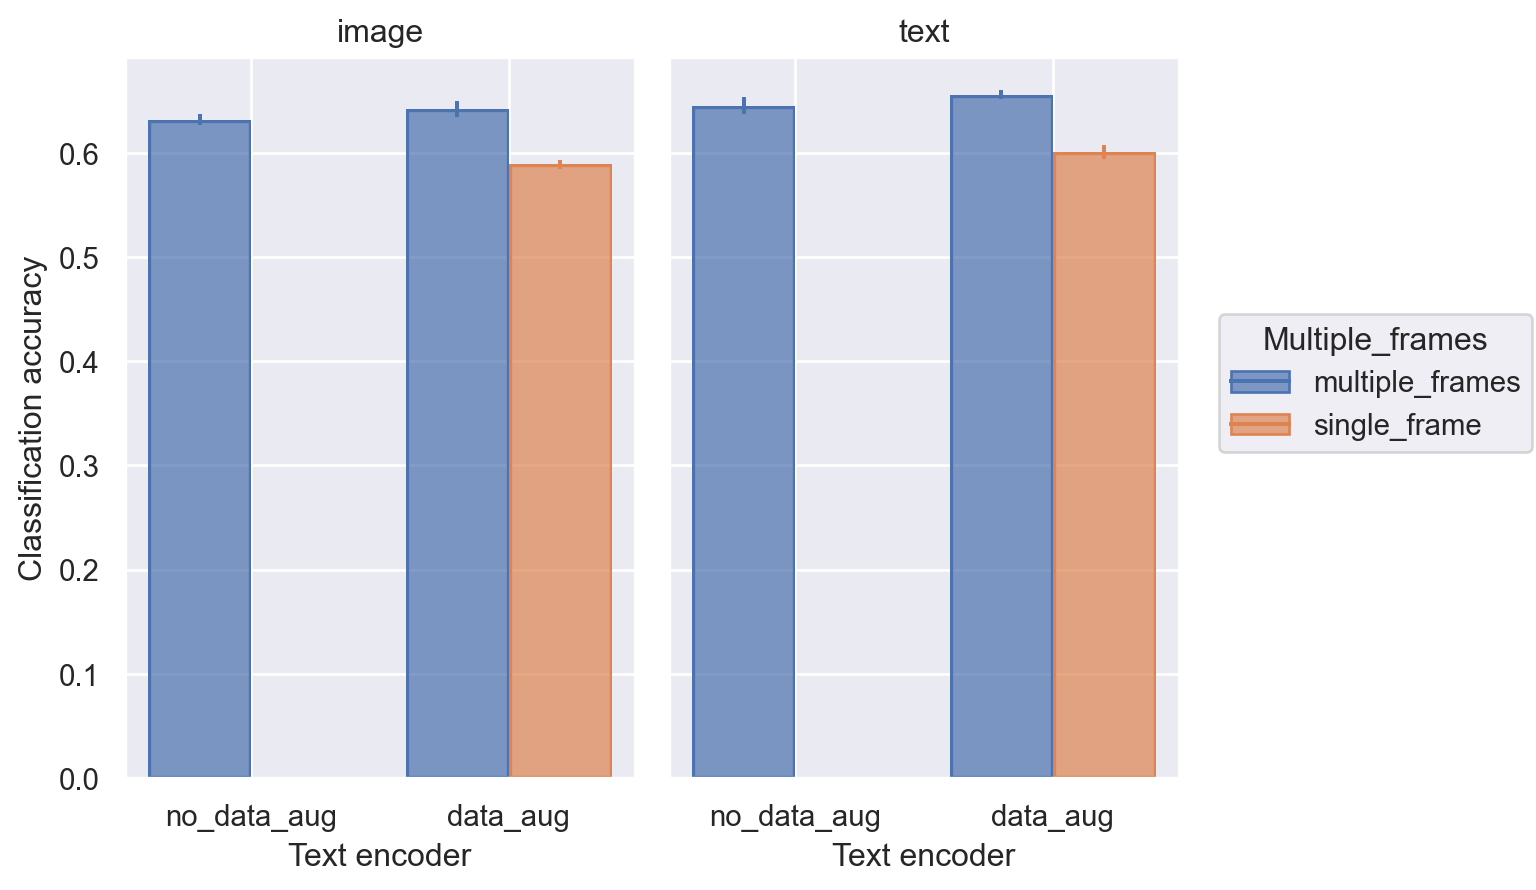

In [15]:
# saycam frozen pre-trained ablations
saycam_summary_ablations = (saycam_results_df
>> filter(_.shuffle_utterances == False, _.cnn == "frozen_pretrained", _.model == "embedding")
>> group_by(_.seed, _.eval_type, _.augment_frames, _.multiple_frames)
>> summarize(correct = _.correct.mean())
>> mutate(augment_frames = _.augment_frames.map({True: 'data_aug', False: 'no_data_aug'}))
>> mutate(multiple_frames = _.multiple_frames.map({True: 'multiple_frames', False: 'single_frame'})))
print(saycam_summary_ablations)

(
    so.Plot(saycam_summary_ablations, x="augment_frames", y="correct", color="multiple_frames")
    .facet("eval_type")
    .add(so.Bar(), so.Agg(), so.Dodge())
    .add(so.Range(), so.Est(errorbar="se"), so.Dodge())
    .label(
        x="Text encoder", y="Classification accuracy",
        color=str.capitalize)
    #.save('../paper/figures/labeled-s-results.pdf', dpi=300, bbox_inches="tight")
)

/home/wv9/code/WaiKeen/miniconda3/envs/multimodal-baby/lib/python3.8/_collections_abc.py:832: MatplotlibDeprecationWarning: 
The savefig.jpeg_quality rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  self[key] = other[key]
/home/wv9/code/WaiKeen/miniconda3/envs/multimodal-baby/lib/python3.8/_collections_abc.py:832: MatplotlibDeprecationWarning: 
The savefig.jpeg_quality rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  self[key] = other[key]


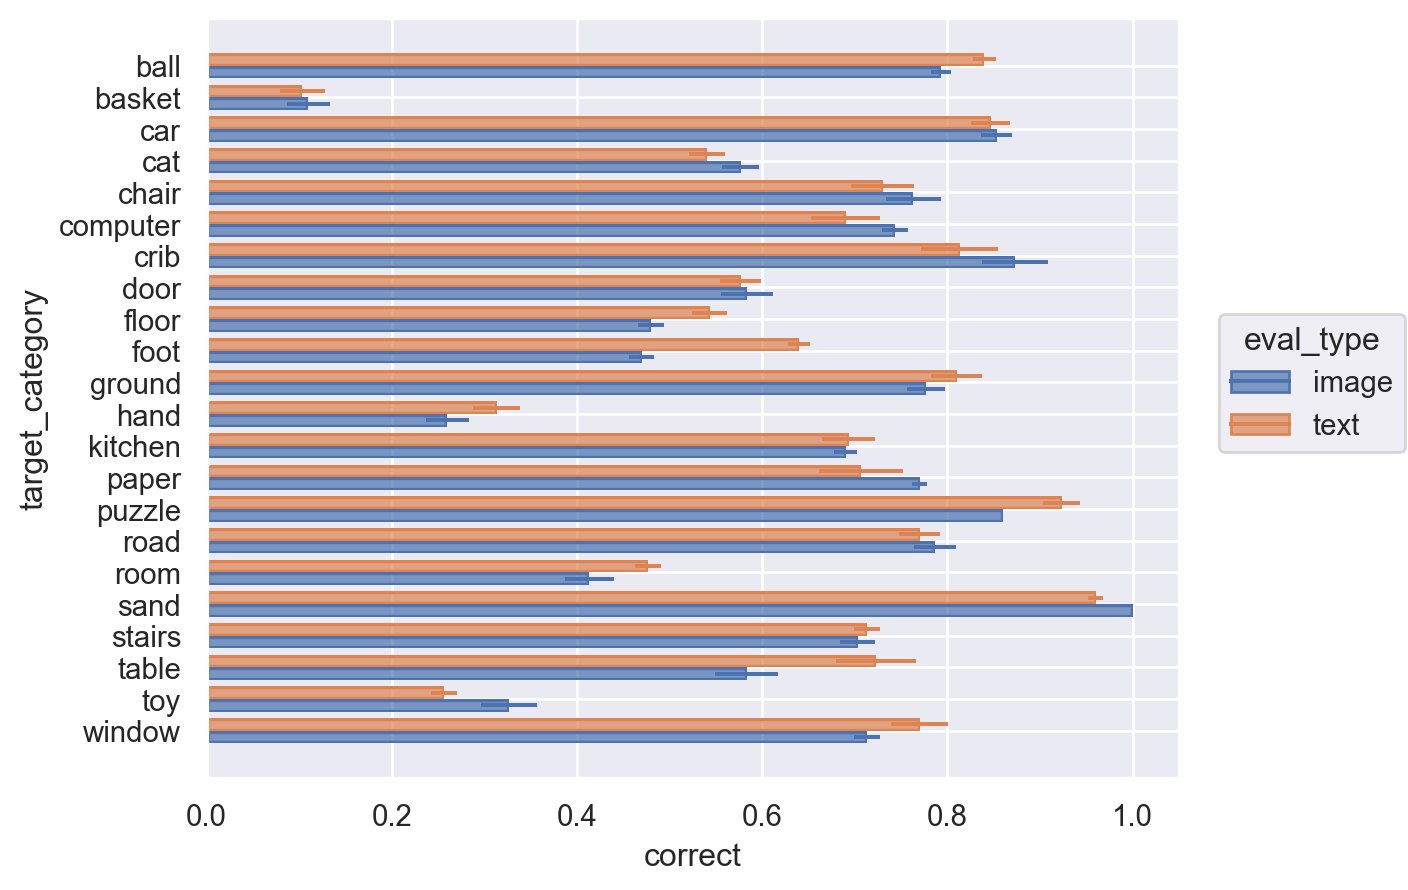

In [18]:
# saycam per object category results
saycam_pretrained_frozen_embedding_results = (saycam_results_df
>> filter(_.shuffle_utterances == False, _.cnn == "frozen_pretrained", _.model == "embedding")
>> group_by(_.target_category, _.seed, _.eval_type)
>> summarize(correct = _.correct.mean())
>> arrange(-_.target_category))

(
    so.Plot(saycam_pretrained_frozen_embedding_results, x="correct", y="target_category", color="eval_type")
    .add(so.Bar(), so.Agg(), so.Dodge())
    .add(so.Range(), so.Est(errorbar="se"), so.Dodge(by=['color']))
    #.save('../paper/figures/labeled-s-results-by-category.pdf', dpi=300, bbox_inches="tight")
)


/home/wv9/code/WaiKeen/miniconda3/envs/multimodal-baby/lib/python3.8/_collections_abc.py:832: MatplotlibDeprecationWarning: 
The savefig.jpeg_quality rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  self[key] = other[key]
/home/wv9/code/WaiKeen/miniconda3/envs/multimodal-baby/lib/python3.8/_collections_abc.py:832: MatplotlibDeprecationWarning: 
The savefig.jpeg_quality rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  self[key] = other[key]


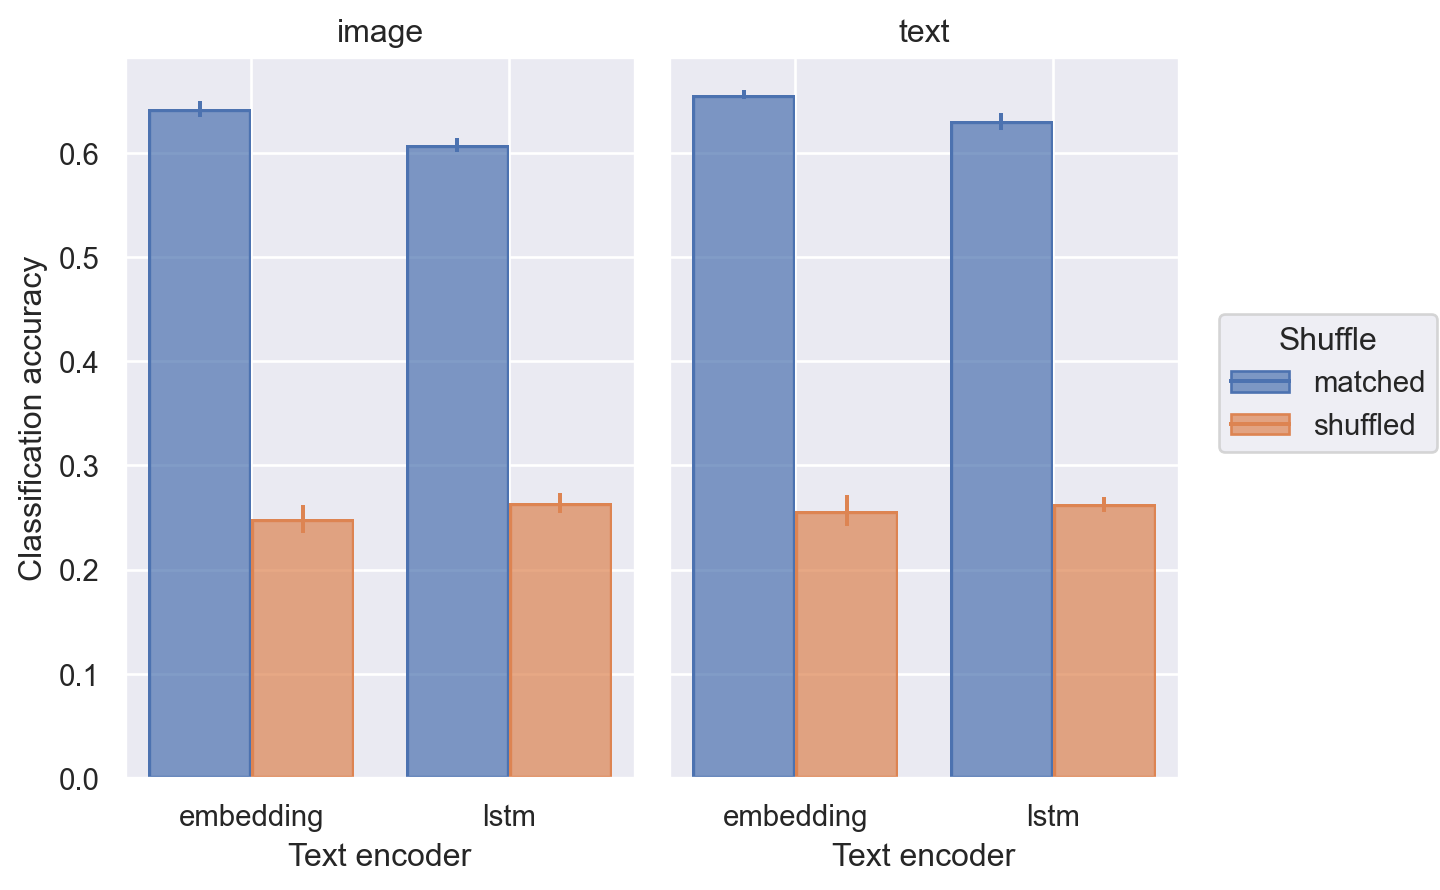

In [19]:
# shuffled results
saycam_shuffled_summary = (saycam_results_df
>> filter(_.cnn == "frozen_pretrained")
>> group_by(_.shuffle_utterances, _.model, _.seed, _.eval_type)
>> summarize(correct = _.correct.mean())
>> mutate(shuffle = _.shuffle_utterances.map({True: 'shuffled', False: 'matched'})))

(
    so.Plot(saycam_shuffled_summary, x="model", y="correct", color="shuffle")
    .facet("eval_type")
    .add(so.Bar(), so.Agg(), so.Dodge())
    .add(so.Range(), so.Est(errorbar="se"), so.Dodge())
    .label(
        x="Text encoder", y="Classification accuracy",
        color=str.capitalize)
    #.save('../paper/figures/labeled-s-matched-vs-shuffled-results.pdf', dpi=300, bbox_inches="tight")
)


In [20]:
# brady object categories results
brady_results_filenames = glob.glob("../results/*object_categories*.json")
print(len(brady_results_filenames))

brady_results = []
for filename in brady_results_filenames:
    with open(filename) as f:
        data = json.load(f)

    result_df = pd.DataFrame(data["data"])
    # print(result_df.columns)
    result_df["target_category"] = result_df["categories"].str[0]
    brady_results.append(result_df)

# combine results
brady_results_df = pd.concat(brady_results)

# calculate summary
brady_summary_diff_init = (brady_results_df
>> filter(_.shuffle_utterances == False)
>> group_by(_.cnn, _.model, _.seed, _.eval_type)
>> summarize(correct = _.correct.mean()))

48


/home/wv9/code/WaiKeen/miniconda3/envs/multimodal-baby/lib/python3.8/_collections_abc.py:832: MatplotlibDeprecationWarning: 
The savefig.jpeg_quality rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  self[key] = other[key]
/home/wv9/code/WaiKeen/miniconda3/envs/multimodal-baby/lib/python3.8/_collections_abc.py:832: MatplotlibDeprecationWarning: 
The savefig.jpeg_quality rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  self[key] = other[key]


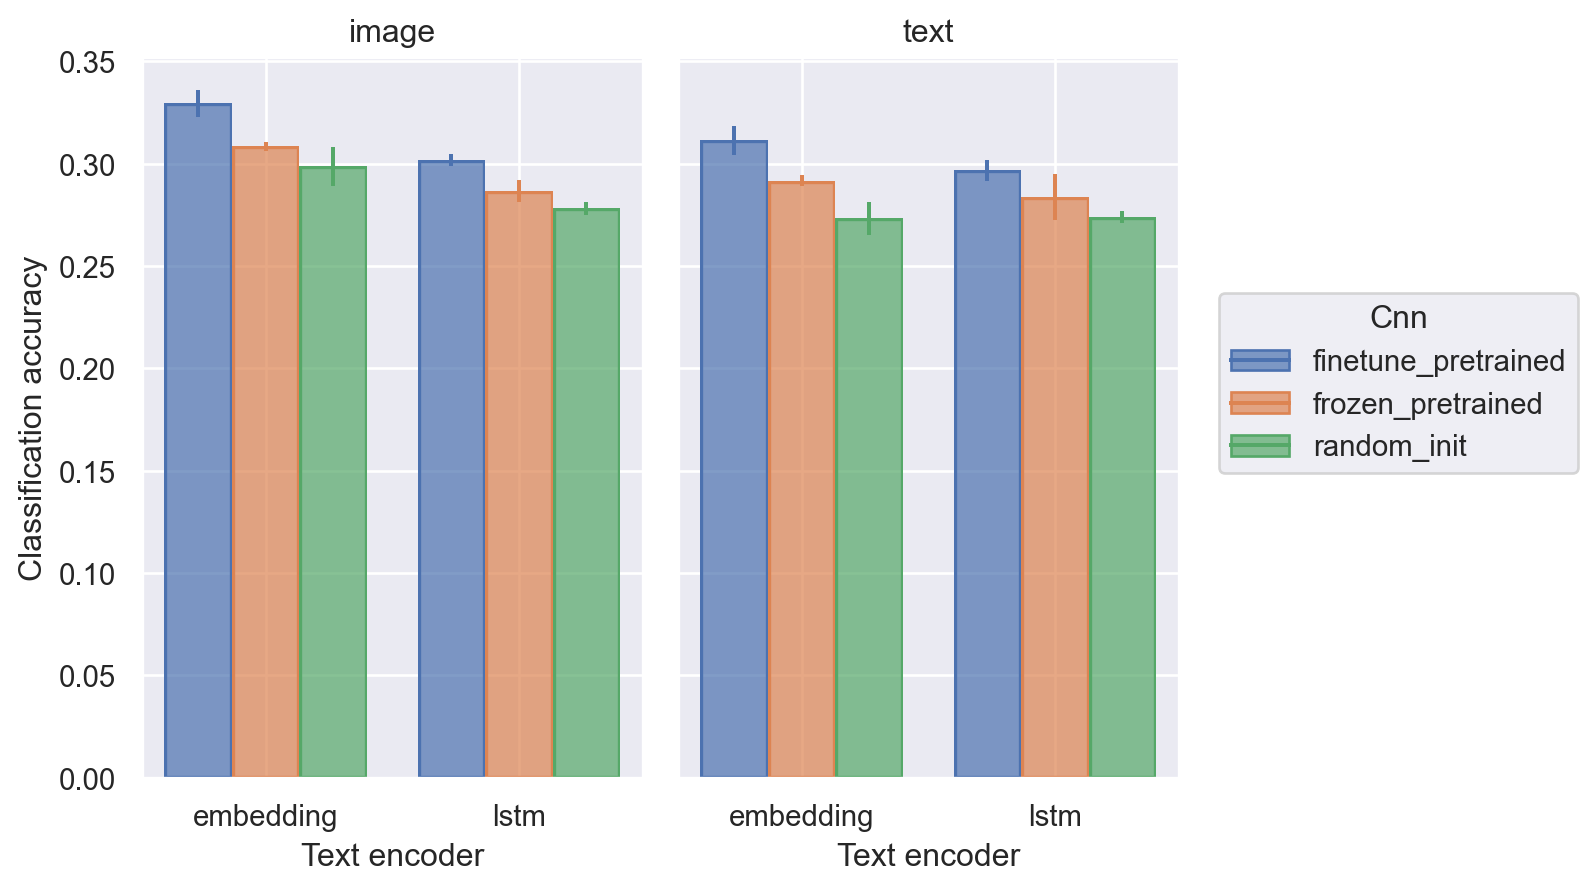

In [21]:
# brady overall results
(
    so.Plot(brady_summary_diff_init, x="model", y="correct", color="cnn")
    .facet("eval_type")
    .add(so.Bar(), so.Agg(), so.Dodge())
    .add(so.Range(), so.Est(errorbar="se"), so.Dodge())
    .label(
        x="Text encoder", y="Classification accuracy",
        color=str.capitalize)
    #.save('../paper/figures/brady-results.pdf', dpi=300, bbox_inches="tight")
)


/home/wv9/code/WaiKeen/miniconda3/envs/multimodal-baby/lib/python3.8/_collections_abc.py:832: MatplotlibDeprecationWarning: 
The savefig.jpeg_quality rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  self[key] = other[key]
/home/wv9/code/WaiKeen/miniconda3/envs/multimodal-baby/lib/python3.8/_collections_abc.py:832: MatplotlibDeprecationWarning: 
The savefig.jpeg_quality rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  self[key] = other[key]


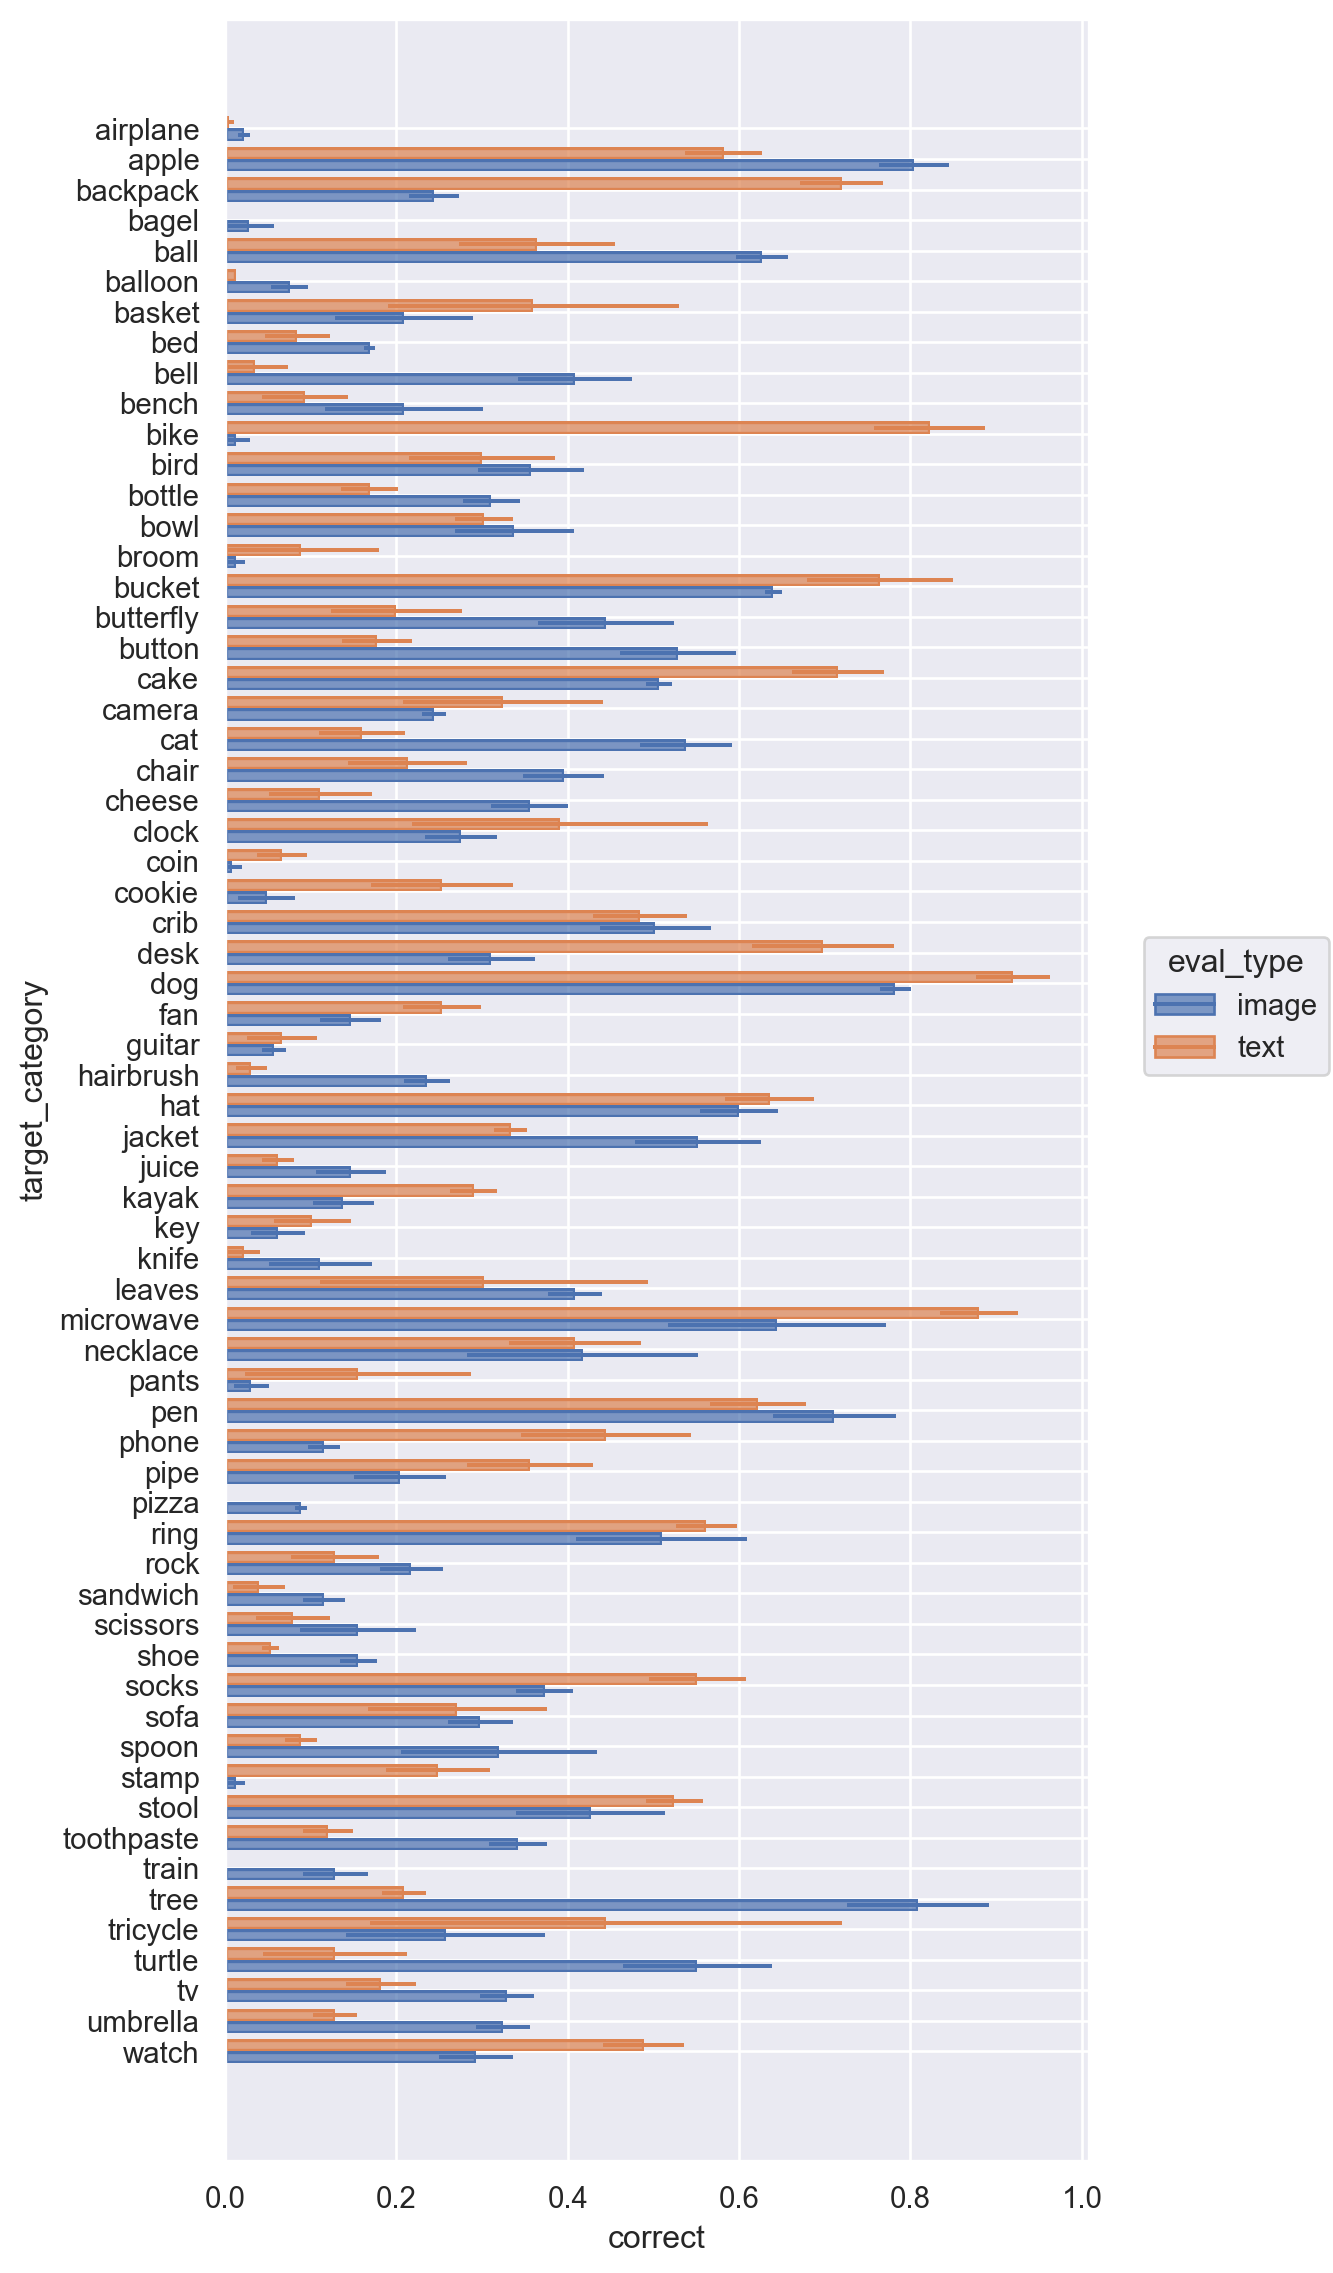

In [22]:
# brady per object category results
brady_pretrained_frozen_embedding_results = (brady_results_df
>> filter(_.shuffle_utterances == False, _.cnn == "frozen_pretrained", _.model == "embedding")
>> group_by(_.target_category, _.seed, _.eval_type)
>> summarize(correct = _.correct.mean())
>> arrange(-_.target_category))

(
    so.Plot(brady_pretrained_frozen_embedding_results, x="correct", y="target_category", color="eval_type")
    .add(so.Bar(), so.Agg(), so.Dodge())
    .add(so.Range(), so.Est(errorbar="se"), so.Dodge(by=['color']))
    .layout(size=(6, 12))
    #.save('../paper/figures/brady-results-by-category.pdf', dpi=300, bbox_inches="tight")
)


/home/wv9/code/WaiKeen/miniconda3/envs/multimodal-baby/lib/python3.8/_collections_abc.py:832: MatplotlibDeprecationWarning: 
The savefig.jpeg_quality rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  self[key] = other[key]
/home/wv9/code/WaiKeen/miniconda3/envs/multimodal-baby/lib/python3.8/_collections_abc.py:832: MatplotlibDeprecationWarning: 
The savefig.jpeg_quality rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  self[key] = other[key]


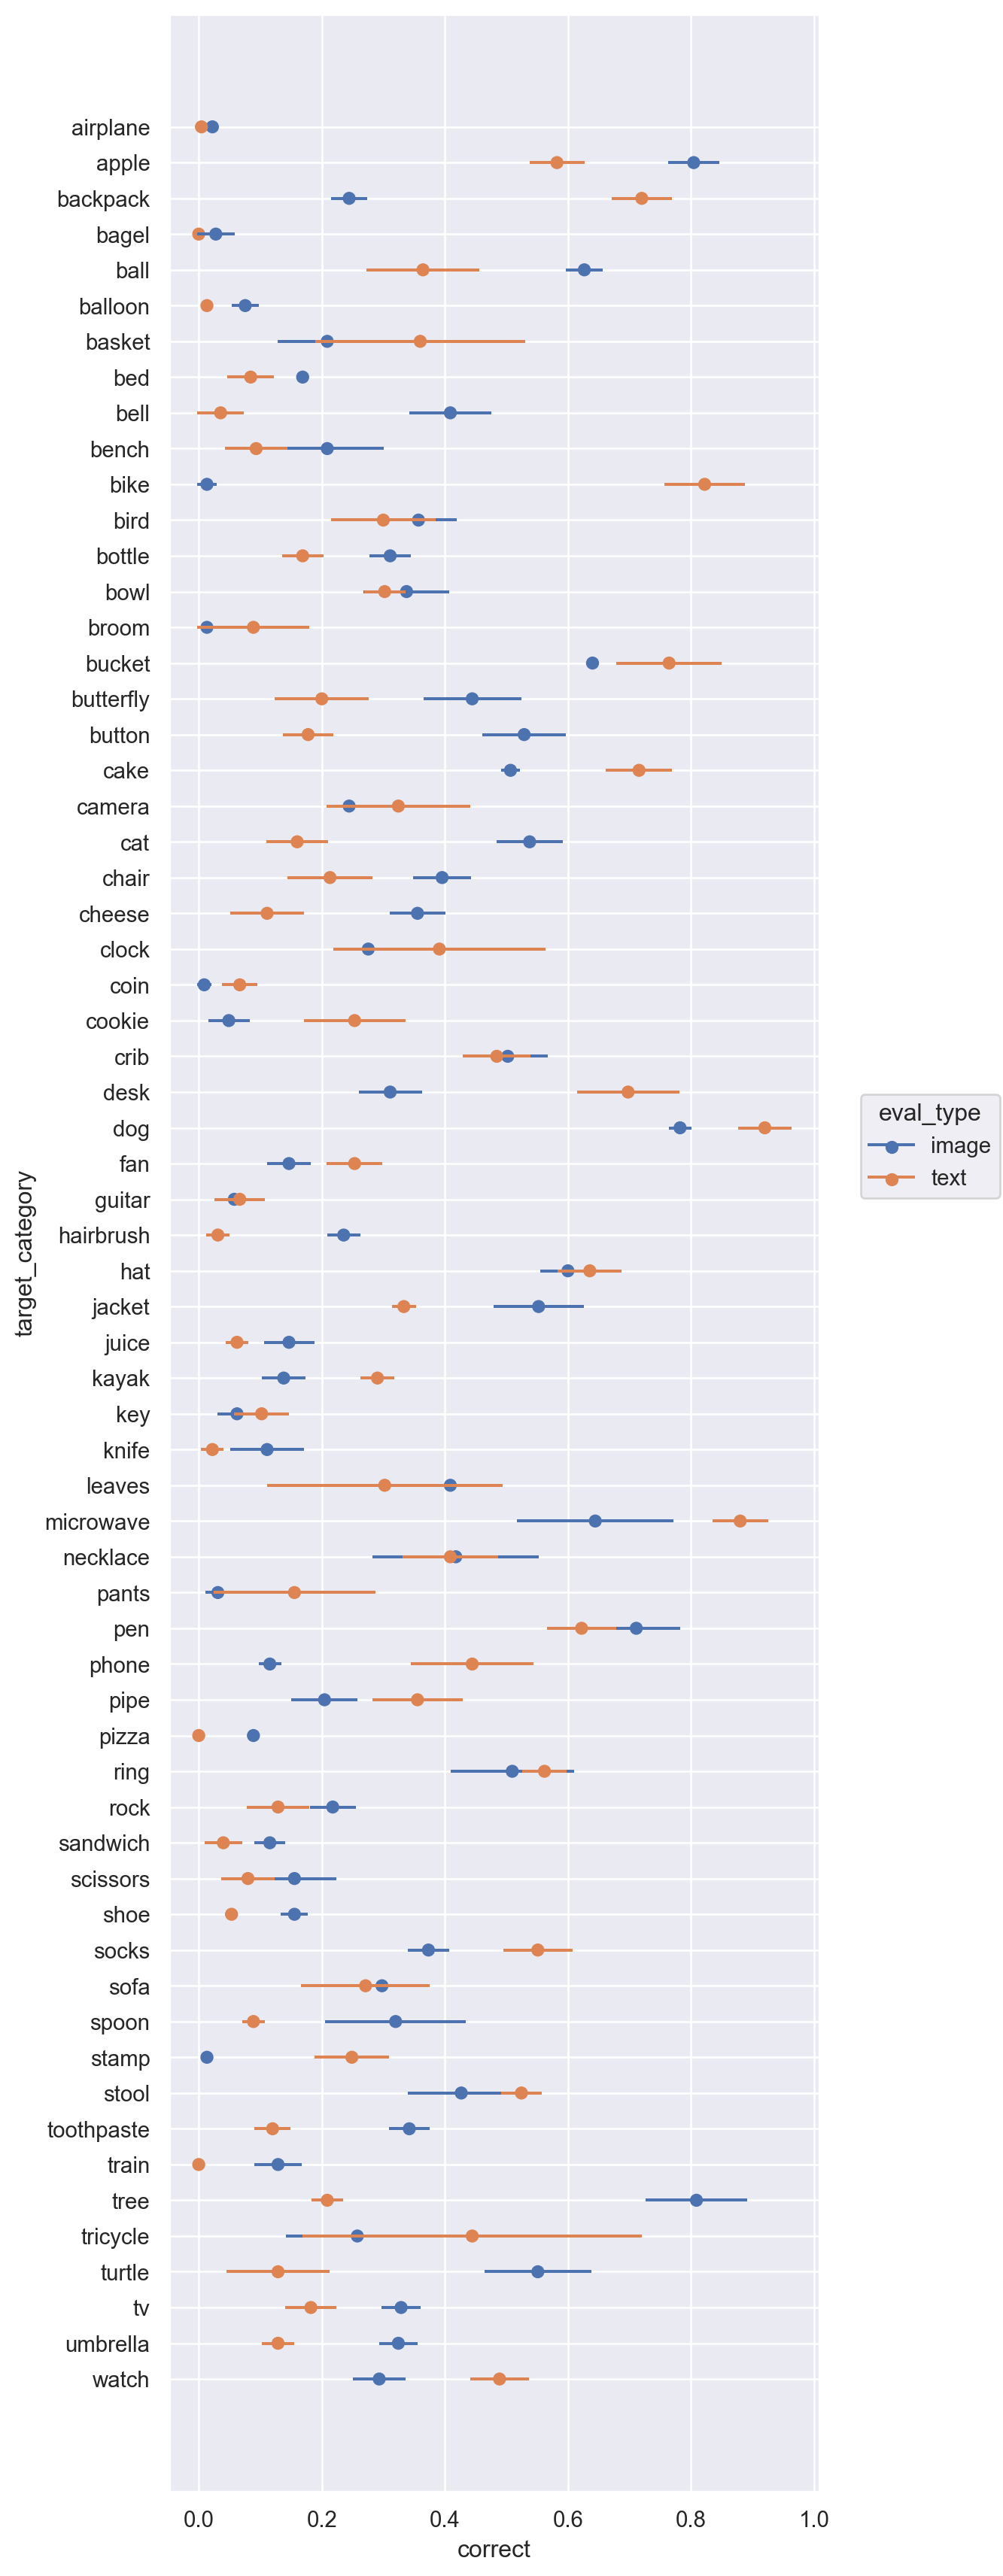

In [23]:
# try plotting as a line graph instead
(
    so.Plot(brady_pretrained_frozen_embedding_results, x="correct", y="target_category", color="eval_type")
    .add(so.Dot(), so.Agg())
    .add(so.Range(), so.Est(errorbar="se"))
    .layout(size=(6, 18))
)


In [24]:
# visualize embeddings
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
normalizer = transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

preprocess = transforms.Compose([
            transforms.Resize((224, 224),
                              interpolation=transforms.InterpolationMode.BICUBIC),
            transforms.ToTensor(),
            normalizer,
        ])

# load embedding checkpoint
checkpoint_name = f"multimodal_text_encoder_embedding_embedding_dim_512_batch_size_8_dropout_i_0.5_lr_0.0001_lr_scheduler_True_weight_decay_0.1_max_epochs_400_seed_0"
checkpoint = glob.glob(f"/home/wv9/code/WaiKeen/multimodal-baby/checkpoints/{checkpoint_name}/epoch*.ckpt")[0]
model = MultiModalLitModel.load_from_checkpoint(checkpoint, map_location=device)
model.eval()
print("")

In [101]:
# get image embeddings
DATA_DIR = Path("/misc/vlgscratch4/LakeGroup/shared_data/S_multimodal")
EVALUATION_FRAMES_DIR = DATA_DIR / "eval_filtered" / "dev"
eval_categories = sorted(os.listdir(EVALUATION_FRAMES_DIR))

all_image_features = []
all_eval_categories = []

for eval_category in eval_categories:
    frames = sorted(glob.glob(os.path.join(EVALUATION_FRAMES_DIR, eval_category, "*.jpeg")))
    
    for frame in frames:
        I = preprocess(Image.open(frame).convert('RGB')).unsqueeze(0).to(device)
        image_features, _ = model.model.encode_image(I)
        all_image_features.append(image_features.squeeze().detach().cpu().numpy())
        all_eval_categories.append(eval_category)

In [102]:
VOCAB_FILENAME = DATA_DIR / "vocab.json"
with open(VOCAB_FILENAME) as f:
    vocab = json.load(f)
    
all_text_features = []

for eval_category in eval_categories:
    text = torch.tensor([vocab[eval_category]]).unsqueeze(0).to(device)
    text_len = torch.tensor([len(text)], dtype=torch.long).to(device)
    text_features, _ = model.model.encode_text(text, text_len)
    all_text_features.append(text_features.squeeze().detach().cpu().numpy())

In [134]:
# get mean image embeddings
all_image_features = np.array(all_image_features)
mean_image_features = []
for i in range(len(eval_categories)):
    idxs = [j for j in range(len(all_eval_categories)) if all_eval_categories[j] == eval_categories[i]]
    curr_image_features = all_image_features[idxs]
    curr_mean_image_features = np.mean(curr_image_features, axis=0)
    mean_image_features.append(curr_mean_image_features)
    
mean_image_features = np.array(mean_image_features)
print(all_image_features.shape)
print(mean_image_features.shape)

(4054, 512)
(22, 512)


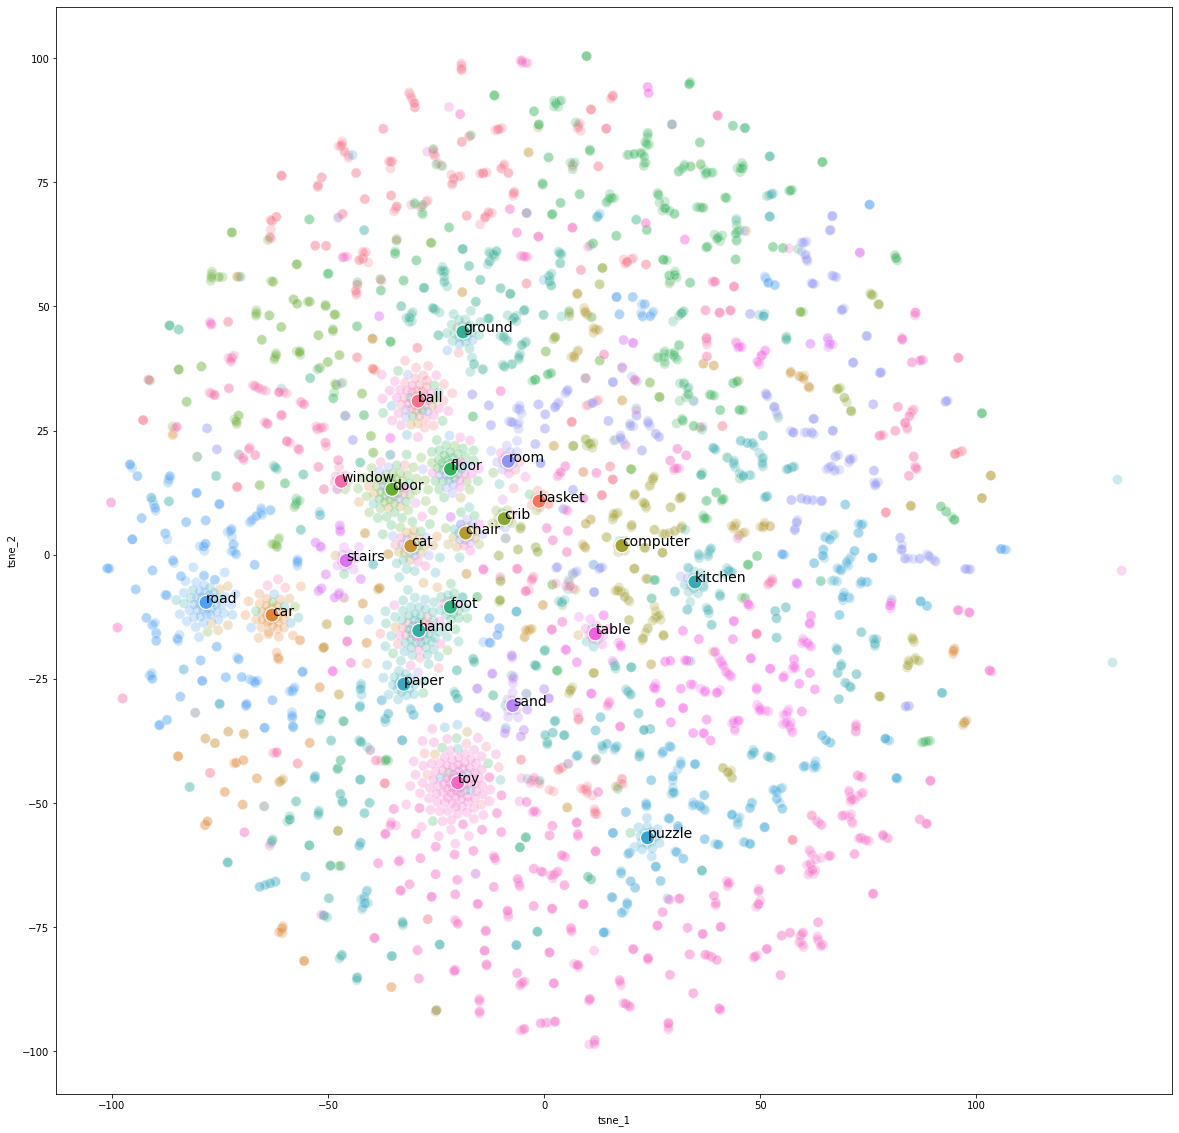

In [135]:
# plot image embeddings
n_components = 2
tsne = TSNE(n_components, perplexity=2)
all_mean_image_features = np.concatenate([all_image_features, mean_image_features])
tsne_result = tsne.fit_transform(all_mean_image_features)
all_tsne_result = tsne_result[:-22]
mean_tsne_result = tsne_result[-22:]
 
# Plot the result of our TSNE with the label color coded
# A lot of the stuff here is about making the plot look pretty and not TSNE
tsne_result_df = pd.DataFrame({'tsne_1': all_tsne_result[:,0], 'tsne_2': all_tsne_result[:,1], 'label': all_eval_categories})
mean_tsne_result_df = pd.DataFrame({'tsne_1': mean_tsne_result[:,0], 'tsne_2': mean_tsne_result[:,1], 'label': eval_categories})
fig = plt.figure(figsize=(20, 20))

ax = plt.gca()
sns.scatterplot(x='tsne_1', y='tsne_2', hue='label', data=tsne_result_df, s=100, legend=False, alpha=0.25)
sns.scatterplot(x='tsne_1', y='tsne_2', hue='label', data=mean_tsne_result_df, s=200, legend=False)
lim = (tsne_result.min()-5, tsne_result.max()+5)
for i, eval_category in enumerate(eval_categories):
    ax.text(mean_tsne_result[i, 0], mean_tsne_result[i, 1], eval_category, size=14)

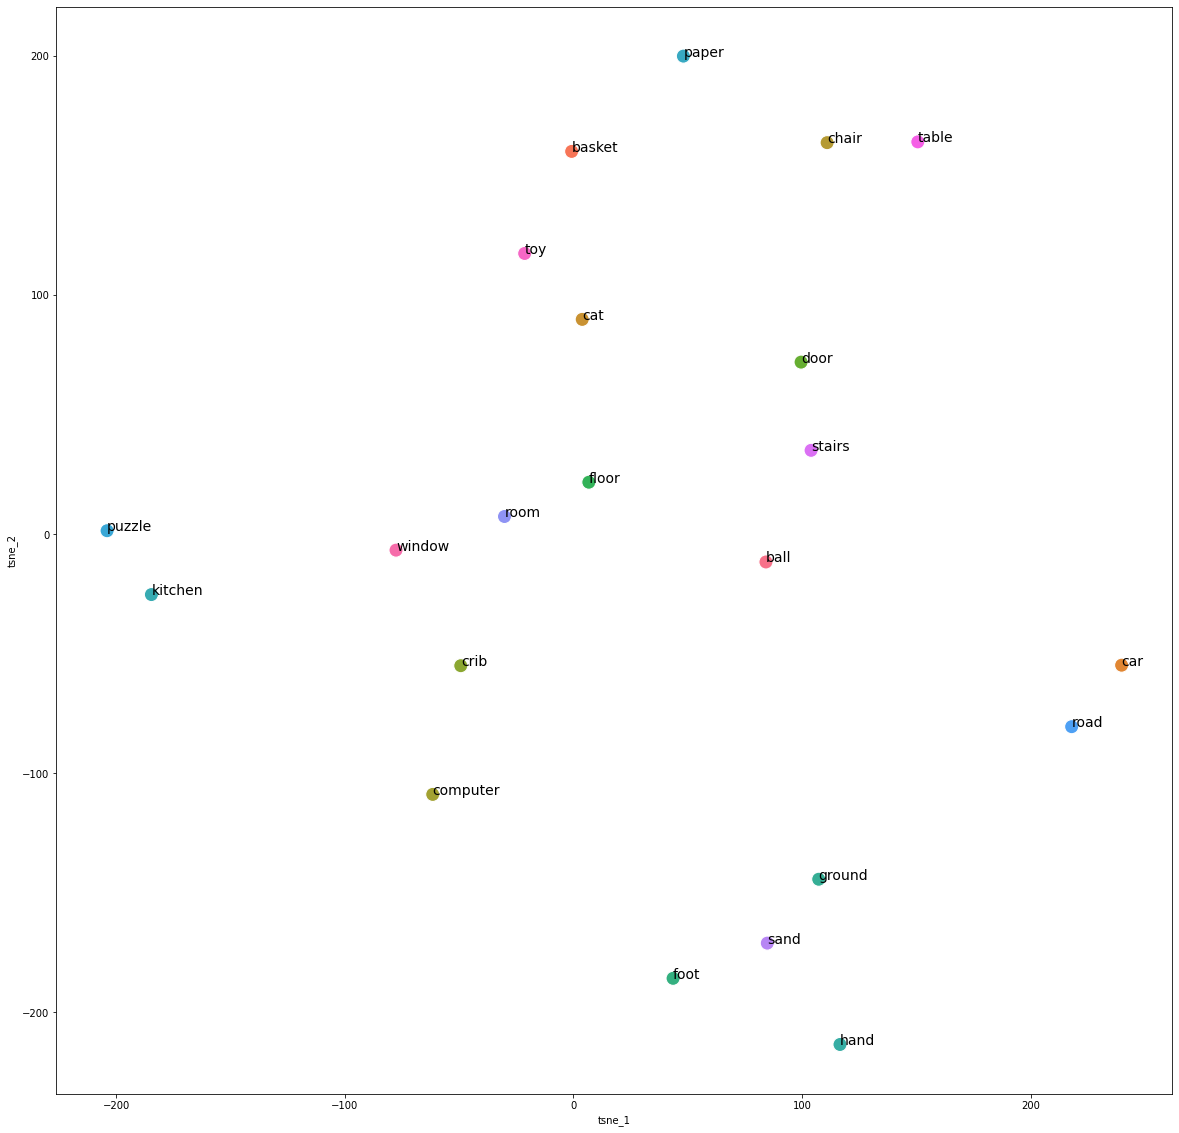

In [136]:
# plot text embeddings
n_components = 2
tsne = TSNE(n_components, perplexity=5)
tsne_result = tsne.fit_transform(all_text_features)
 
# Plot the result of our TSNE with the label color coded
# A lot of the stuff here is about making the plot look pretty and not TSNE
tsne_result_df = pd.DataFrame({'tsne_1': tsne_result[:,0], 'tsne_2': tsne_result[:,1], 'label': eval_categories})
fig = plt.figure(figsize=(20, 20))

ax = plt.gca()
sns.scatterplot(x='tsne_1', y='tsne_2', hue='label', data=tsne_result_df, s=200, legend=False)
lim = (tsne_result.min()-5, tsne_result.max()+5)
for i, eval_category in enumerate(eval_categories):
    ax.text(tsne_result[i, 0], tsne_result[i, 1], eval_category, size=14)

In [138]:
# recompute all image features
all_image_features = []
all_eval_categories = []

for eval_category in eval_categories:
    frames = sorted(glob.glob(os.path.join(EVALUATION_FRAMES_DIR, eval_category, "*.jpeg")))
    
    for frame in frames:
        I = preprocess(Image.open(frame).convert('RGB')).unsqueeze(0).to(device)
        image_features, _ = model.model.encode_image(I)
        all_image_features.append(image_features.squeeze().detach().cpu().numpy())
        all_eval_categories.append(eval_category)

In [139]:
n_components = 2
tsne = TSNE(n_components, perplexity=2)
all_mean_image_features = np.concatenate([all_image_features, mean_image_features])
tsne_result = tsne.fit_transform(all_mean_image_features)
all_tsne_result = tsne_result[:-22]
mean_tsne_result = tsne_result[-22:]

In [ ]:
category_idx = eval_categories.index("stairs")
sims = []
for image_feature in all_image_features:
    sim = np.power(np.dot(image_feature, all_text_features[category_idx]) / (np.linalg.norm(image_feature)*np.linalg.norm(all_text_features[category_idx])), 2)
    sims.append(sim)
    
sims = np.array(sims)
sims = (sims - np.min(sims))/np.ptp(sims)
    
tsne_result_df = pd.DataFrame({'tsne_1': tsne_result[:,0], 'tsne_2': tsne_result[:,1]})
mean_tsne_result_df = pd.DataFrame({'tsne_1': mean_tsne_result[:,0], 'tsne_2': mean_tsne_result[:,1], 'label': eval_categories})

fig = plt.figure(figsize=(20, 20))

ax = plt.gca()
sns.scatterplot(x='tsne_1', y='tsne_2', data=tsne_result_df, s=100, color='blue', legend='full', alpha=sims)
lim = (tsne_result.min()-5, tsne_result.max()+5)
sns.scatterplot(x='tsne_1', y='tsne_2', hue='label', data=mean_tsne_result_df, s=200, legend=False)
for i, eval_category in enumerate(eval_categories):
    ax.text(mean_tsne_result[i, 0], mean_tsne_result[i, 1], eval_category, size=14)